In [1]:
from shapely.geometry import Point 
from shapely.geometry import LineString
import pandas as pd
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import datetime
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

# Adding CSV data

In [2]:
tornado_911 = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
cadd_tornado = pd.read_csv('../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv', skiprows = 3)
derecho_911 = pd.read_csv('../data/911_Phone Calls_Derecho_050320_050420.csv')
cadd_derecho = pd.read_csv('../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv', skiprows = 3)

# Fixing  CSV columns

In [3]:
tornado_911.columns = ['time', 'calltype', 'lat', 'lng', 'cell_tower_address']
derecho_911.columns = ['time', 'calltype', 'lat', 'lng', 'cell_tower_address']
cadd_tornado.columns = ['time', 'location', 'lat', 'lng', 'incident_type']
cadd_derecho.columns = ['time', 'location', 'lat', 'lng', 'incident_type']

In [4]:
tornado_911.time = pd.to_datetime(tornado_911.time)
derecho_911.time = pd.to_datetime(derecho_911.time)
cadd_tornado.time = pd.to_datetime(cadd_tornado.time)
cadd_derecho.time = pd.to_datetime(cadd_derecho.time)

In [5]:
tornado_911 = tornado_911.dropna(subset = ['lat', 'lng'])
derecho_911 = derecho_911.dropna(subset = ['lat', 'lng'])
cadd_tornado = cadd_tornado.dropna(subset = ['lat', 'lng'])
cadd_derecho = cadd_derecho.dropna(subset = ['lat', 'lng'])

In [6]:
tornado_911['geometry'] = tornado_911.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
derecho_911['geometry'] = derecho_911.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
cadd_tornado['geometry'] = cadd_tornado.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
cadd_derecho['geometry'] = cadd_derecho.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

# Adding geojson data

In [7]:
damage_points = gpd.read_file('../data/damage_points.geojson')
path_polygons = gpd.read_file('../data/path_polygons.geojson')
tornado_paths = gpd.read_file('../data/tornado_paths.geojson')

# Fixing geojson columns

In [8]:
damage_points.stormdate = damage_points.stormdate.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
damage_points.surveydate = damage_points.surveydate.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths.stormdate = tornado_paths.stormdate.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths.starttime = tornado_paths.starttime.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths.endtime = tornado_paths.endtime.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))

# Making GeoDataFrames

In [9]:
geo_tornado_911 = gpd.GeoDataFrame(tornado_911, crs = tornado_paths.crs, geometry = tornado_911.geometry)
geo_derecho_911 = gpd.GeoDataFrame(derecho_911, crs = tornado_paths.crs, geometry = derecho_911.geometry)
geo_cadd_tornado = gpd.GeoDataFrame(cadd_tornado, crs = tornado_paths.crs, geometry = cadd_tornado.geometry)
geo_cadd_derecho = gpd.GeoDataFrame(cadd_derecho, crs = tornado_paths.crs, geometry = cadd_derecho.geometry)

# Filtering to the Nashville Tornado

In [10]:
nashville_tornado = tornado_paths.loc[tornado_paths.event_id == 'Nashville']
nashville_path = path_polygons.geometry.iloc[np.r_[4, 10:25, 26:35]]
nashville_path = nashville_path.reset_index()
nashville_path = nashville_path.drop(columns = ['index'])
nashville_damage = gpd.sjoin(damage_points, nashville_path, how = 'inner', op = 'within')
nashville_damage = nashville_damage.drop_duplicates(keep = 'first', subset = ['geometry'])

# Nashville Damage by Type

In [11]:
nashville_damage.head(1)

objectid           stormdate          surveydate      event_id  damage  \
0   2047717 2020-03-03 00:57:00 2020-03-04 09:28:00  Mount Juliet       2   

                             damage_txt              dod_txt efscale  \
0  One- or Two-Family Residences (FR12)  All walls collapsed     EF3   

  damage_dir windspeed  ...  qc  dod  surveytype  \
0        N/A       155  ...   Y    9        None   

                                 globalid edit_user edit_time comments  \
0  {FE82BBAC-ABF8-4562-81F6-A527829FBFFE}      None      None     none   

  path_guid                    geometry  index_right  
0      None  POINT (-86.51628 36.18344)            0  

[1 rows x 28 columns]

In [108]:
damage_points.dtypes

objectid                       int64
stormdate             datetime64[ns]
surveydate            datetime64[ns]
event_id                      object
damage                         int64
damage_txt                    object
dod_txt                       object
efscale                       object
damage_dir                    object
windspeed                     object
injuries                       int64
deaths                         int64
lat                          float64
lon                          float64
office                        object
image                         object
gps_horiz_accuracy            object
device_id                     object
qc                            object
dod                            int64
surveytype                    object
globalid                      object
edit_user                     object
edit_time                     object
comments                      object
path_guid                     object
geometry                    geometry
d

In [128]:
#damage_points.damage_txt = damage_points.damage_txt.astype(str)

In [129]:
#damage_points.damage_txt.dtype

dtype('O')

In [121]:
nash_damage = nashville_damage.damage_txt.value_counts()

<AxesSubplot:>

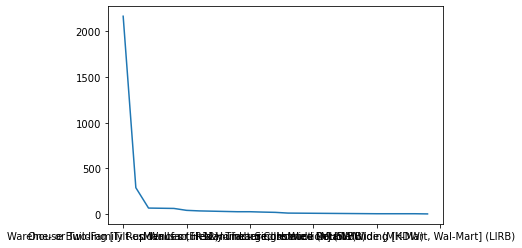

In [122]:
nash_damage.plot()

In [123]:
# plt.figure(figsize = (10,12))
# plt.barh('damage_type', 'count', data = counts, color = (0.5,0.1,0.5,0.6))

# plt.xticks(rotation = 50)
# plt.xlabel('count of damage')
# plt.ylabel('damage type')
# plt.title('instances of damage across nashville')
# plt.show()

NameError: name 'counts' is not defined

<Figure size 720x864 with 0 Axes>

In [124]:
Other = damage_points.loc[damage_points.damage_txt == 'Other (O)']

Trees = damage_points.loc[(damage_points.damage_txt == 'Trees: Hardwood (TH)')
                              |(damage_points.damage_txt == 'Trees: Softwood (TS)')]

Residential = damage_points.loc[(damage_points.damage_txt == 'One- or Two-Family Residences (FR12)')
                              |(damage_points.damage_txt == 'Masonry Apartment or Motel Building (MAM)')
                              |(damage_points.damage_txt == 'Manufactured Home - Single Wide (MHSW)')
                              |(damage_points.damage_txt == 'Apartments, Condos, Townhouses [3 stories or less] (ACT)')
                              |(damage_points.damage_txt == 'Manufactured Home - Double Wide (MHDW)')
                              |(damage_points.damage_txt == 'Motel (M)')]

Commercial = damage_points.loc[(damage_points.damage_txt == 'Small Barns or Farm Outbuildings (SBO)')
                              |(damage_points.damage_txt == 'Metal Building System (MBS)')
                              |(damage_points.damage_txt == 'Low-Rise Building [1-4 Stories] (LRB)')
                              |(damage_points.damage_txt == 'Electrical Transmission Lines (ETL)')
                              |(damage_points.damage_txt == 'Small Professional Building [Doctors Office, Branch Banks] (SPB)')
                              |(damage_points.damage_txt == 'Institutional Building [Hospital, Government or University Building] (IB)')
                              |(damage_points.damage_txt == 'Large, Isolated Retail Building [K-Mart, Wal-Mart] (LIRB)')                    
                              |(damage_points.damage_txt == 'Junior or Senior High School (JHSH)')                      
                              |(damage_points.damage_txt == 'Strip Mall (SM)') 
                              |(damage_points.damage_txt == 'Elementary School [Single Story; Interior or Exterior Hallways] (ES)') 
                              |(damage_points.damage_txt == 'Mid-Rise Building [5-20 Stories] (MRB)')  
                              |(damage_points.damage_txt == 'Free-Standing Towers (FST)' )
                              |(damage_points.damage_txt == 'Service Station Canopy (SSC)') 
                              |(damage_points.damage_txt == 'Small Retail Building [Fast Food Restaurants] (SRB)')]


# Mapping the Nashville tornado damage

In [132]:
Other

objectid           stormdate          surveydate  \
9      2320477 2020-03-03 00:32:00 2021-04-17 18:29:00   
200    2047751 2020-03-03 00:36:00 2020-03-03 15:39:00   
206    2047757 2020-03-03 00:36:00 2020-03-03 15:42:00   
1000   2067236 2020-03-03 00:57:00 2020-04-04 08:24:00   
1129   2046078 2020-03-03 00:49:00 2020-03-03 10:34:00   
1884   2047805 2020-03-03 01:53:00 2020-03-04 12:42:00   
2492   2086137 2020-03-03 00:44:00 2020-04-16 03:44:00   
2711   2091275 2020-03-03 00:41:00 2020-04-20 13:00:00   
3965   2320477 2020-03-03 00:32:00 2021-04-17 18:29:00   

                    event_id  damage damage_txt       dod_txt efscale  \
9                  Nashville      29  Other (O)  Other damage     EF0   
200   John Tune Airport area      29  Other (O)  Other damage     EF2   
206   John Tune Airport area      29  Other (O)  Other damage     EF2   
1000            Mount Juliet      29  Other (O)  Other damage     EF0   
1129                Donelson      29  Other (O)  Other damage     EF2   
1884              Cookeville      29  Other (O)  Other damage     EF2   
2492                              29  Other (O)  Other damage     EF0   
2711                              29  Other (O)  Other damage     EF0   
3965               Nashville      29  Other (O)  Other damage     EF0   

     damage_dir windspeed  ...  device_id  qc  dod  surveytype  \
9           N/A        70  ...       None   Y    1        None   
200         N/A       125  ...       None   Y    1        None   
206         N/A       125  ...       None   Y    1        None   
1000      S/180        75  ...       None   Y    1        None   
1129        N/A       120  ...       None   Y    1        None   
1884        N/A       130  ...       None   Y    1        None   
2492        N/A        85  ...       None   Y    1        None   
2711        N/A        70  ...       None   Y    1        None   
3965        N/A        70  ...       None   Y    1        None   

                                    globalid edit_user edit_time  \
9     {5071191E-4409-4F75-BD83-BE52ED30723C}      None      None   
200   {82BED698-F9FF-4905-9C20-C4CBF75B1287}      None      None   
206   {25135387-1512-4B8A-9599-FCDCEC74C924}      None      None   
1000  {8549539E-C0C9-4F7F-B498-7F8DC22B9BBE}      None      None   
1129  {2A326B65-52A6-44EE-88E0-638AADCAB89F}      None      None   
1884  {860375BA-525E-4559-A9AD-EBC3A66A05DB}      None      None   
2492  {49319DD4-4830-42F6-A71A-562B1BE87253}      None      None   
2711  {0C51A8F0-8248-45F2-AE99-9CCD0E038F44}      None      None   
3965  {5071191E-4409-4F75-BD83-BE52ED30723C}      None      None   

                                               comments path_guid  \
9     Boathouse and dock blown northward and heavily...      None   
200                                  debris from hangar      None   
206                                                none      None   
1000                     RV overturned toward the south      None   
1129                             Street sign and debris      None   
1884                   Utility poles were not damaged\n      None   
2492                  Home under construction collapsed      None   
2711           Damage to scoreboard at baseball stadium      None   
3965  Boathouse and dock blown northward and heavily...      None   

                        geometry  
9     POINT (-86.94269 36.17417)  
200   POINT (-86.88232 36.17780)  
206   POINT (-86.88342 36.17597)  
1000  POINT (-86.51833 36.18663)  
1129  POINT (-86.64904 36.18402)  
1884  POINT (-85.56685 36.17481)  
2492  POINT (-86.74379 36.17619)  
2711  POINT (-86.78490 36.17185)  
3965  POINT (-86.94269 36.17417)  

[9 rows x 27 columns]

In [126]:
style = {'fillColor': 'red', 'color': 'red'}
style2 = {'fillColor': 'lightgreen', 'color': 'lightgreen'}
startloc = [36.1627, -86.7816]

#mapping tornado path

map_damage = folium.Map(location = startloc, zoom_start = 12)

folium.GeoJson(nashville_tornado.geometry, style_function = lambda x:style).add_to(map_damage)
folium.GeoJson(nashville_path.geometry, style_function = lambda x:style2).add_to(map_damage)

# #mapping residential damage points

# for row_index, row_values in Residential.iterrows():
#     loc = [row_values['lat'], row_values['lon']]
#     pop = [row_values['dod_txt']]
#     icon = folium.Icon(color = 'red', icon = 'house-damage', prefix = 'fa')
#     marker = folium.Marker(location = loc, popup = pop, icon = icon)
#     marker.add_to(map_damage)

# #mapping commercial damage points    
    
# for row_index, row_values in Commercial.iterrows():
#     loc = [row_values['lat'], row_values['lon']]
#     pop = [row_values['dod_txt']]
#     icon = folium.Icon(color = 'blue', icon = 'house-damage', prefix = 'fa')
#     marker = folium.Marker(location = loc, popup = pop, icon = icon)
#     marker.add_to(map_damage)
    
#mapping tree damage points
    
for row_index, row_values in Trees.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = [row_values['dod_txt']]
    icon = folium.Icon(color = 'green', icon = 'tree', prefix = 'fa')
    marker = folium.Marker(location = loc, popup = pop, icon = icon)
    marker.add_to(map_damage)

#mapping other/unknown damage points
    
for row_index, row_values in Other.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = [row_values['dod_txt']]
    icon = folium.Icon(color = 'gray', icon = 'question-circle', prefix = 'fa')
    marker = folium.Marker(location = loc, popup = pop, icon = icon)
    marker.add_to(map_damage)

    
map_damage

# Commenting out below  residential and commercial damage map portions due to heavy ram use, temporary measure until code rewrite

In [130]:
style = {'fillColor': 'red', 'color': 'red'}
style2 = {'fillColor': 'lightgreen', 'color': 'lightgreen'}
startloc = [36.1627, -86.7816]

#mapping tornado path

map_damage = folium.Map(location = startloc, zoom_start = 12)

folium.GeoJson(nashville_tornado.geometry, style_function = lambda x:style).add_to(map_damage)
folium.GeoJson(nashville_path.geometry, style_function = lambda x:style2).add_to(map_damage)

#mapping residential damage points

for row_index, row_values in Residential.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = [row_values['dod_txt']]
    icon = folium.Icon(color = 'red', icon = 'house-damage', prefix = 'fa')
    marker = folium.Marker(location = loc, popup = pop, icon = icon)
    marker.add_to(map_damage)

# #mapping commercial damage points    
    
# for row_index, row_values in Commercial.iterrows():
#     loc = [row_values['lat'], row_values['lon']]
#     pop = [row_values['dod_txt']]
#     icon = folium.Icon(color = 'blue', icon = 'house-damage', prefix = 'fa')
#     marker = folium.Marker(location = loc, popup = pop, icon = icon)
#     marker.add_to(map_damage)
    
map_damage